In [12]:
import math
import random
import numpy as np
from collections import defaultdict, OrderedDict
import pdb
from collections import Counter
from numpy import genfromtxt
import scipy.io
from scipy import stats

import random
import Ipynb_importer
from node import Node
import math
import random
import numpy as np
from collections import defaultdict, OrderedDict
import pdb
import pandas as pd

In [13]:
import numpy as np

class DecisionTree:
    def __init__(self, root=None):
        self.root = root
        
    def entropy(self, C, D, b,a): 
        p = b - C
        q = a - D
        count = -(self.half_entropy(C, D) + self.half_entropy(D, C) 
                 + self.half_entropy(p, q) + self.half_entropy(q, p))/(b + a)
        return count
    
    def segmenter(self, data, label, random_forest=False, mtry=1):
        min_entropy= float('inf')

        ft_select=None 
        thresh=None 
        spliti = 0
        
        if random_forest == True:
            if mtry <= 0: 
                mtry = int(np.sqrt(len(data.columns) - 1))
            elif mtry < 1: 
                mtry = int((len(data.columns) - 1) * mtry)
            features = data.drop(label, 1).sample(mtry, axis=1)
        else:
            features = data.drop(label, 1).columns
        for f in features:
            sortedby_f = data.sort_values(f)
            iterv = sortedby_f[f].__iter__()
            iterl = sortedby_f[label].__iter__()
            b, a = self.data_metric(sortedby_f, label)           
            feature= next(iterv) 
            lbl=next(iterl)
            i= 0
            C=0
            D=0
            beta_iter = sortedby_f.drop_duplicates(subset=f, keep='first')[f].__iter__()
            next(beta_iter)
            for value in beta_iter:
                try:
                    while feature != value:
                        i += 1
                        if lbl == 0:C += 1
                        else:D += 1
                        feature= next(iterv)
                        lbl = next(iterl)
                except StopIteration: continue
                entropy = self.entropy(C, D, b, a)
                #Checking the entropy of the split
                if entropy < min_entropy:
                    min_entropy= entropy
                    ft_select= f
                    thresh=value
                    spliti=i
        if ft_select == None:
            return None, None, ft_select, thresh
        sorted_data = data.sort_values(ft_select)
        left = sorted_data.iloc[:spliti]
        right = sorted_data.iloc[spliti:]

        return left, right, ft_select, thresh

    def train(self, tr_data, label, depth, random_forest=False, ntree=0):
        self.root = self.tree_leaf(tr_data, label, depth, random_forest, ntree)
       
    def tree_leaf(self,tr_data, label, depth, random_forest=False, ntree=0):
            labels = tr_data[label].unique()
            if depth == 0 or len(labels) == 1:
                return Leaf(labels[0])

            lefts, rights, ft_select, thresh = self.segmenter(tr_data, label, random_forest, ntree)
            
            if lefts is None:
                lbl = tr_data[label].value_counts().argmax()
                return Leaf(lbl)
            left = self.tree_leaf(lefts, label, depth - 1, random_forest, ntree)
            right = self.tree_leaf(rights, label, depth - 1, random_forest, ntree)
            
            return Node(left, right, ft_select, thresh)
        
    def predict(self, data, verbose=False):
        return self.root.predict(data, verbose)

    def data_metric(self, data, label):
        b=0
        a=0
        a = sum(data[label])
        b= len(data[label])-a
        return b, a
    
    def half_entropy(self, s, t):
        if s == 0: return 0
        else: return s * np.log2(s / (s + t))

In [ ]:
class RandomForest:
    def __init__(self, ntree):
        self.ntree = ntree
        self.forest = []

    def train(self, tr_data, label, depth=float('inf')):
        bag_num = len(tr_data)
        for i in range(int(self.ntree)):
            t = DecisionTree()
            t.train(tr_data.sample(bag_num, replace=True), label, depth, random_forest=True)
            self.forest.append(t)

    def predict(self, data):
        pred=[]
        vote0=0
        vote1=0
        #Prediction by Ensamble by maximum vote
        for t in self.forest:
            pred.append(t.predict(data))
            if pred[-1] == 0: vote0 += 1
            else: vote1 += 1
        if vote0 > vote1: return 0
        else: return 1


In [ ]:
def train(data, label, model, depth=float('inf'), ntree=None):
    randomed = data.sample(frac=1)
    k = int(len(randomed)*0.2)
    validate = randomed[:k]
    trainset = randomed[k:]
    if ntree == None:
        m = model()
    else:
        m = model(ntree=ntree)
    m.train(trainset, label, depth)
    return m, trainset, validate
    
def accuracy(data, label, model, depth=float('inf'), n=None):
    m, trainset,validation = train(data, label, model, depth, n)
    tr_acc= 0 
    v_acc = 0     
    for _, p in trainset.iterrows():
        if m.predict(p) == p[label]:
            tr_acc += 1    
    for _, p in validation.iterrows():
        if m.predict(p) == p[label]:
            v_acc += 1
    t=tr_acc / len(trainset)
    v=v_acc / len(validation)            
    print('Training Accuracy: {}\nValidation Accuracy: {}'.format(t, v))
    return m, v

In [14]:
class Node:
    def __init__(self, left, right, split_f, split_val):
        self.left=left
        self.right = right
        self.split_f = split_f
        self.split_val = split_val
    def status(self):
        return self.split_f,self.split_val
    def predict(self, data, verbose=False):
        if data[self.split_f] < self.split_val:
            if verbose:
                print('Feature {}: {} < {} -> left'.format(self.split_f, 
                                                           data[self.split_f], self.split_val))
            return self.left.predict(data, verbose)
        if verbose:
            print('Feature {}: {} >= {} -> right'.format(self.split_f, 
                                                       data[self.split_f], self.split_val))
        return self.right.predict(data, verbose)
    def is_leaf(self):
        return False

class Leaf:
    def __init__(self, label):
        self.label = label
        
    def is_leaf(self):
        return True
    def status(self):
        return self.label
    def predict(self, data, verbose=False):
        if verbose:
            print('Leaf Prediction:',self.label)
        return self.label      

In [17]:
spam_data= scipy.io.loadmat('datasets/spam-dataset/spam_data.mat')
feature = ['pain', 'private', 'bank', 'money', 'drug', 'spam', 
           'prescription', 'creative', 'height','featured', 'differ',
           'width', 'other', 'energy', 'business', 'message', 'volumes',
           'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 
           'record', 'out', ';', '$', '#', '!', '(', '[', '&','not_ham']     

In [ ]:
data = np.concatenate((spam_data['training_data'],spam_data['training_labels'].T),axis=1)
spam_train = pd.DataFrame(data=data, columns=feature, dtype='object')
spam_test = pd.DataFrame(data=spam_data['test_data'], columns=feature[:-1], dtype='object')

In [18]:
accuracy_dt = accuracy(spam_train,'not_ham', DecisionTree)

C:\Users\zhuwe\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Training Accuracy: 0.8864185596906718
Validation Accuracy: 0.8268858800773694


In [19]:
accuracy_rf = accuracy(spam_train,'not_ham', RandomForest, 30,20)

C:\Users\zhuwe\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Training Accuracy: 0.8583856935717739
Validation Accuracy: 0.8433268858800773


In [35]:
rf1,_ = accuracy(spam_tr,'not_ham', RandomForest, 30,20)


C:\Users\zhuwe\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Training Accuracy: 0.8644272595456742
Validation Accuracy: 0.8288201160541586


1

In [ ]:
y_pred = []
for i in range(len(spam_test)):
    y_pred.append(rf1.predict(spam_test.iloc[i,:]))
y_pred

y_pred = np.array(y_pred)

In [45]:
# A code snippet to help you save your results into a kaggle accepted csv
import pandas as pd
import numpy as np

# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission2.csv', index_label='Id')

In [46]:
results_to_csv(y_pred)

In [20]:
accplot=[]
for c in range(1,41):
    hyperparameter_tune, acc=accuracy(spam_train,'not_ham',DecisionTree,c)
    accplot.append(acc)  

Training Accuracy: 0.764137264378927
Validation Accuracy: 0.7591876208897486
Training Accuracy: 0.7834702754954084
Validation Accuracy: 0.7640232108317214
Training Accuracy: 0.7095215079748671
Validation Accuracy: 0.7117988394584139
Training Accuracy: 0.7941034316094732
Validation Accuracy: 0.8027079303675049
Training Accuracy: 0.652005799903335
Validation Accuracy: 0.6595744680851063
Training Accuracy: 0.7399710004833253
Validation Accuracy: 0.7553191489361702
Training Accuracy: 0.6959884001933301
Validation Accuracy: 0.6750483558994197
Training Accuracy: 0.736346060898985
Validation Accuracy: 0.7311411992263056
Training Accuracy: 0.7938617689705172
Validation Accuracy: 0.7727272727272727
Training Accuracy: 0.8064282261962301
Validation Accuracy: 0.7852998065764023
Training Accuracy: 0.7148380860318995
Validation Accuracy: 0.6972920696324951


C:\Users\zhuwe\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Training Accuracy: 0.8105364910584824
Validation Accuracy: 0.781431334622824
Training Accuracy: 0.7344127597873369
Validation Accuracy: 0.6818181818181818
Training Accuracy: 0.7699371677138714
Validation Accuracy: 0.7263056092843327
Training Accuracy: 0.8521024649589174
Validation Accuracy: 0.8288201160541586
Training Accuracy: 0.7368293861768971
Validation Accuracy: 0.718568665377176
Training Accuracy: 0.8322861285645239
Validation Accuracy: 0.8085106382978723
Training Accuracy: 0.7467375543740937
Validation Accuracy: 0.7040618955512572
Training Accuracy: 0.8680521991300145
Validation Accuracy: 0.8249516441005803
Training Accuracy: 0.7725954567423876
Validation Accuracy: 0.7272727272727273
Training Accuracy: 0.7825036249395844
Validation Accuracy: 0.7475822050290135
Training Accuracy: 0.8666022232962783
Validation Accuracy: 0.8384912959381045
Training Accuracy: 0.804736587723538
Validation Accuracy: 0.7427466150870407
Training Accuracy: 0.8724021266312229
Validation Accuracy: 0.828820

NameError: name 'plt' is not defined

Text(0,0.5,'Accuracy')

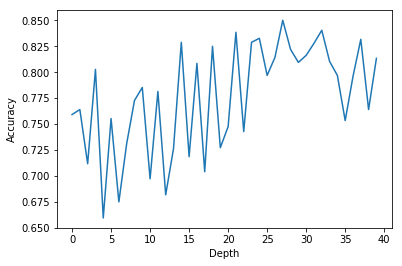

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accplot)
plt.xlabel('Depth')
plt.ylabel('Accuracy')

In [48]:
dt=DecisionTree()
dt.train(spam_train,'not_ham',3)

In [51]:
print(dt.root.status())
print(dt.root.left.status())
print(dt.root.right.status())
print(dt.root.left.left.status())
print(dt.root.left.right.status())
print(dt.root.right.left.status())
print(dt.root.right.right.status())
print(dt.root.left.left.left.status())
print(dt.root.left.left.right.status())


('!', 1.0)
('meter', 1.0)
('meter', 1.0)
('(', 1.0)
0.0
('&', 1.0)
0.0
0.0
0.0
